# Generative Learning: From Autoencoders to Variational Autoencoders (VAEs) ✨

**Overview — what this notebook covers**

This tutorial explores two foundational generative models that are useful both for representation learning and for generation:

- **Autoencoder (AE)** — a deterministic neural network trained to compress and reconstruct data. Useful for dimensionality reduction, denoising and as a building block for other methods.  
- **Variational Autoencoder (VAE)** — a probabilistic autoencoder that imposes a structure on the latent space. VAEs are true generative models: after training you can sample from the latent prior to generate novel data.

We use the MNIST handwritten digits dataset as a simple, convenient playground.

**Learning goals**

- Understand the architecture of an AE and a VAE (encoder, bottleneck, decoder).  
- Understand training objectives: reconstruction loss, KL divergence, and the evidence lower bound (ELBO).  
- See how to implement, train and use both models on MNIST.  
- Learn practical tips: choice of loss, latent size, sampling, and visualization of results.

---

## Part 1 — Standard Autoencoder (AE): intuition, architecture, and training

**What is an autoencoder?**  
An autoencoder is a neural network trained to reproduce its input. It consists of two parts:

- **Encoder** ($f_\phi$): maps the input $x$ (for images, a flattened pixel vector) to a low-dimensional representation $z = f_\phi(x)$.  
- **Decoder** $g_\theta$: reconstructs the input from the representation, $\hat{x} = g_\theta(z)$.

The network is trained to minimize a reconstruction loss $L_r(x, \hat{x})$. Common choices are mean squared error (MSE) for continuous-valued pixels or binary cross-entropy for normalized pixels in [0,1].

**Why AEs are useful (but not fully generative)**

- They learn compact, task-agnostic feature representations (useful for visualization, compression, or as pretraining).  
- However, a vanilla AE maps each input deterministically to a single point in latent space — the latent space may be disorganized. Sampling a random point from a simple prior (e.g., $N(0,I)$) and decoding it usually does *not* produce realistic images. This is the limitation the VAE addresses.

**Notebook flow for the Autoencoder section**

1. Data loading: MNIST images normalized to [0,1].  
2. Build a fully-connected autoencoder with a small latent dimension.  
3. Train using MSE reconstruction loss and Adam optimizer.  
4. Visualize reconstructions to assess quality.

In [1]:
# Install necessary libraries if not present
!pip install torch torchvision matplotlib -q

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Data loading and preprocessing (MNIST)

We use the MNIST dataset of 28×28 grayscale handwritten digits. The code converts images to Tensors with pixel values in [0,1]. Using a `DataLoader` with a moderately large batch size (128) speeds up training.

Practical note: for autoencoders with sigmoid output it's common to keep pixel values in [0,1] and use either **binary cross-entropy** or **MSE** as reconstruction loss. In this notebook the AE uses MSE for clarity and numeric stability on MNIST.

In [2]:
# Load the MNIST dataset
transform = transforms.ToTensor() # Converts images to PyTorch tensors with pixels in [0, 1]

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 520kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.87MB/s]


### Building the Autoencoder — architecture details and choices

The Autoencoder implemented below is a simple fully-connected (dense) model:

- **Encoder** compresses the flattened 784-dimensional input down to a `latent_dim` vector via intermediate layers (784 → 128 → 64 → latent_dim). Activation functions are ReLU except for the final encoder linear layer (which outputs the raw latent vector).
- **Decoder** reverses the process (latent_dim → 64 → 128 → 784) and ends with a **sigmoid** activation to map outputs to [0,1].

Why these design choices?

- ReLU activations are a standard default for internal layers due to good optimization properties.
- The final Sigmoid constrains output pixel values to [0,1], matching the input normalization.
- A small `latent_dim` forces the model to compress information, which encourages learning meaningful features.

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        # Encoder: Compresses 784 pixels -> 128 -> 64 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

        # Decoder: Decompresses latent_dim -> 64 -> 128 -> 784 pixels
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid() # Use Sigmoid to ensure output pixels are between 0 and 1
        )

    def forward(self, x):
        # The input x is flattened before being passed to the encoder
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Training the Autoencoder

Key hyperparameters and their roles:
- `latent_dim_ae`: dimensionality of the bottleneck. Smaller values force stronger compression; larger values may memorize.
- `lr_ae`: learning rate for the optimizer (Adam is a sensible default).
- `epochs_ae`: number of passes over the dataset. For this simple demo 10 epochs are sufficient to see reconstructions.

Training procedure (per batch):
1. Flatten the batch of images to shape `(batch_size, 784)`.  
2. Forward pass: compute reconstructions $\hat{x}$.  
3. Compute reconstruction loss: MSE between $\hat{x}$ and the original $x$.  
4. Backpropagate gradients and take an optimizer step.  
5. Optionally log the loss per epoch and monitor validation reconstructions.

Why MSE?  
MSE treats each pixel independently and penalizes squared differences. For binary-like pixels (as in MNIST) BCE is another valid choice; MSE often works well and is easy to interpret.

Tips for better training:
- Normalize/scale inputs as appropriate for your final activation. Here inputs are already in [0,1] to match Sigmoid output.  
- If reconstructions look blurry, consider increasing latent dimension or using convolutional encoders/decoders.  
- For image generation it's common to switch to convolutional architectures (Conv-AE) which better capture spatial structure.

In [4]:
# Hyperparameters
latent_dim_ae = 32
lr_ae = 1e-3
epochs_ae = 10

# Initialize model, loss, and optimizer
ae_model = Autoencoder(latent_dim=latent_dim_ae).to(device)
criterion_ae = nn.MSELoss() # Mean Squared Error is a good choice for reconstruction loss
optimizer_ae = optim.Adam(ae_model.parameters(), lr=lr_ae)

# Training Loop
for epoch in range(epochs_ae):
    for data in train_loader:
        imgs, _ = data
        imgs = imgs.view(imgs.size(0), -1).to(device) # Flatten images

        # Forward pass
        outputs = ae_model(imgs)
        loss = criterion_ae(outputs, imgs)

        # Backward pass and optimization
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()

    print(f'Epoch [{epoch+1}/{epochs_ae}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0347
Epoch [2/10], Loss: 0.0271
Epoch [3/10], Loss: 0.0222
Epoch [4/10], Loss: 0.0210
Epoch [5/10], Loss: 0.0184
Epoch [6/10], Loss: 0.0161
Epoch [7/10], Loss: 0.0165
Epoch [8/10], Loss: 0.0150
Epoch [9/10], Loss: 0.0160
Epoch [10/10], Loss: 0.0154


### Visualizing reconstructions — how to interpret results

After training, we visualize original test images side-by-side with their reconstructions. This qualitative check answers:

- Does the AE preserve the main structure of digits (strokes, shape)?  
- Are fine details preserved or lost?  
- Are certain digits reconstructed better than others?

Common observations:
- Small latent sizes compress aggressively → reconstructions may be blurry but capture global shape.
- Larger latent sizes help with detail but may overfit and lose some generalization.
- If reconstructions look noisy, try lowering the learning rate or training longer.

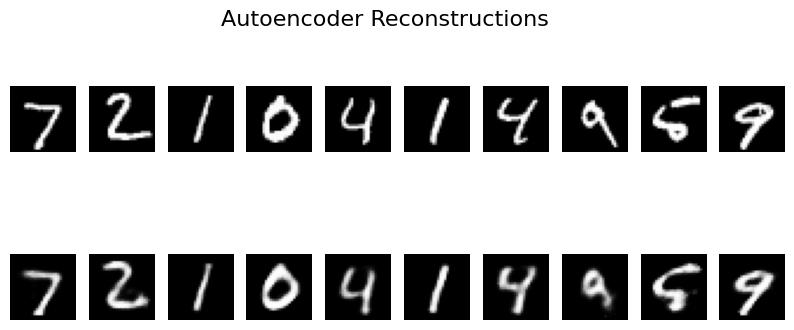

In [5]:
def visualize_reconstructions(model, data_loader, title):
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        data = next(iter(data_loader))
        imgs, _ = data
        imgs = imgs.view(imgs.size(0), -1).to(device)

        # Get reconstructions
        reconstructions = model(imgs).cpu()
        imgs = imgs.cpu()

        # Plot
        plt.figure(figsize=(10, 4))
        plt.suptitle(title, fontsize=16)
        for i in range(10):
            # Original images
            plt.subplot(2, 10, i + 1)
            plt.imshow(imgs[i].view(28, 28), cmap='gray')
            plt.axis('off')

            # Reconstructed images
            plt.subplot(2, 10, i + 11)
            plt.imshow(reconstructions[i].view(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

visualize_reconstructions(ae_model, test_loader, title="Autoencoder Reconstructions")

The AE demonstrates good reconstruction ability but **does not provide a well-organized latent distribution** for sampling. To generate new, realistic digits we need a model that explicitly shapes the latent space — enter the Variational Autoencoder (VAE).

## Part 2 — Variational Autoencoder (VAE): probabilistic modeling and generation

A VAE is a true generative model. It improves upon the AE by introducing a probabilistic twist.

Instead of mapping an input to a **single point** in the latent space, the VAE's encoder maps it to a **probability distribution** (a Gaussian distribution defined by a mean `μ` and a standard deviation `σ`).

**Key Concepts:**
- **Probabilistic Encoder:** Outputs `μ` and `σ` that define a region in the latent space.
- **Reparameterization Trick:** We sample a point `z` from this distribution to feed to the decoder. This trick ($z = \mu + \epsilon \cdot \sigma$) allows gradients to flow through the network during backpropagation, even though we're sampling.
- **New Loss Function:** The VAE loss has two parts:
  1.  **Reconstruction Loss:** Same as the AE, ensuring the output looks like the input.
  2.  **KL Divergence Loss:** This is a regularizer that forces the distributions generated by the encoder to be close to a standard normal distribution (mean=0, variance=1). This organizes the latent space, making it smooth and continuous—perfect for generation!

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder shared layers
        self.encoder_shared = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU()
        )
        # Encoder branches for mean and log-variance
        self.fc_mu = nn.Linear(128, latent_dim) # Predicts the mean (μ)
        self.fc_logvar = nn.Linear(128, latent_dim) # Predicts the log-variance (log(σ^2))

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_shared(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        """The reparameterization trick."""
        std = torch.exp(0.5 * logvar) # σ = exp(0.5 * log(σ^2))
        eps = torch.randn_like(std) # ε ~ N(0, 1)
        return mu + eps * std # z = μ + ε * σ

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
# VAE Loss Function
def vae_loss_function(recon_x, x, mu, logvar):
    # 1. Reconstruction Loss (using Binary Cross-Entropy for pixel-wise comparison)
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')

    # 2. KL Divergence Loss (the regularizer)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# Hyperparameters
latent_dim_vae = 20 # Can use a smaller latent space
lr_vae = 1e-3
epochs_vae = 10

# Initialize model and optimizer
vae_model = VAE(latent_dim=latent_dim_vae).to(device)
optimizer_vae = optim.Adam(vae_model.parameters(), lr=lr_vae)

# VAE Training Loop
for epoch in range(epochs_vae):
    for data in train_loader:
        imgs, _ = data
        imgs = imgs.to(device)

        # Forward pass
        recon_imgs, mu, logvar = vae_model(imgs)
        loss = vae_loss_function(recon_imgs, imgs, mu, logvar)

        # Backward pass and optimization
        optimizer_vae.zero_grad()
        loss.backward()
        optimizer_vae.step()

    print(f'Epoch [{epoch+1}/{epochs_vae}], Loss: {loss.item() / len(imgs):.4f}')

Epoch [1/10], Loss: 147.1987
Epoch [2/10], Loss: 128.6483
Epoch [3/10], Loss: 124.7908
Epoch [4/10], Loss: 118.7543
Epoch [5/10], Loss: 116.3932
Epoch [6/10], Loss: 112.1913
Epoch [7/10], Loss: 111.4076
Epoch [8/10], Loss: 110.8416
Epoch [9/10], Loss: 102.9690
Epoch [10/10], Loss: 108.7816


### Generating new data and sampling from the latent space

This is the most exciting part. Because the VAE's latent space is regularized and continuous, we can sample random points from it and decode them to generate brand new, realistic-looking digits.

Remember: the quality of generations depends strongly on architecture, latent dimensionality, and capacity of encoder/decoder. For higher-quality images, convolutional VAEs or more advanced generative models (GANs, diffusion models) are commonly used.

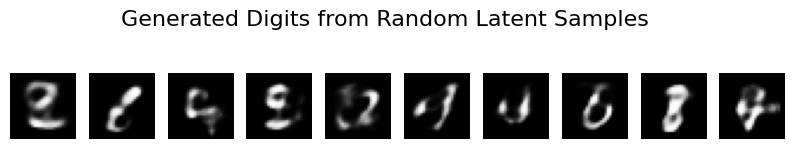

In [8]:
def generate_digits(model, num_images=10):
    model.eval()
    with torch.no_grad():
        # Sample random points from a standard normal distribution (our latent space)
        z = torch.randn(num_images, latent_dim_vae).to(device)

        # Decode these points to generate images
        generated_imgs = model.decode(z).cpu()

        # Plot the generated images
        plt.figure(figsize=(10, 2))
        plt.suptitle("Generated Digits from Random Latent Samples", fontsize=16)
        for i in range(num_images):
            plt.subplot(1, 10, i + 1)
            plt.imshow(generated_imgs[i].view(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

generate_digits(vae_model, num_images=10)

## Conclusion — comparing AE and VAE, practical takeaways

**Summary of differences (intuitions):**

We've built both an Autoencoder and a Variational Autoencoder from scratch. Let's summarize the key differences:

- **AE:** deterministic mapping x → z; good for compression and reconstruction but not for principled generation from a prior.  
- **VAE:** probabilistic encoder $q_\phi(z|x)$; trains encoder to match a simple prior via a KL penalty, which yields a structured latent space suitable for sampling.

| Feature | **Autoencoder (AE)** | **Variational Autoencoder (VAE)** |
| :--- | :--- | :--- |
| **Primary Use** | Dimensionality Reduction, Compression | **Generative Modeling**, Feature Learning |
| **Latent Space** | Irregular, non-continuous | **Smooth, regularized, continuous** |
| **Encoder Output** | A single vector (a point) | A probability distribution (mean & variance) |
| **Loss Function** | Reconstruction Loss only | Reconstruction Loss + **KL Divergence Loss** |
| **Can Generate New Data?** | Not reliably | **Yes!** This is its main purpose. |

VAEs are a foundational concept in generative AI and have paved the way for more complex models like Generative Adversarial Networks (GANs) and Diffusion Models.

**Practical tips & next steps:**

- Use **convolutional** encoder/decoder for better image modeling (Conv-AE / Conv-VAE).  
- Try different reconstruction losses (BCE vs MSE) depending on data scaling.  
- Experiment with latent dimension: smaller gives stronger compression; larger gives more capacity.    
- For higher quality generation explore GANs or diffusion models; VAEs are often a good, stable baseline.